In [1]:
# This refers to "autopsy cohort" database of https://doi.org/10.1016/j.cell.2011.11.060 (2012).
# This author did not have access to "adjuvant cohort" database that is also used by the paper.

In [2]:
# Constants and Functions:
cDebug <- c(FALSE, TRUE)[1] # TRUE for debugging.
c.nchar.max <- nchar("22-04-2022") # alt: 10.
my.paste.Y <- function(dmyVec, yy.prefix="20", my.split="-"){
    my.debug(dmyVec)
    dmY <- paste0(dmyVec[2], my.split, dmyVec[1], my.split, paste0(yy.prefix, dmyVec[3])) # beware: mdy not dmy!
    return(dmY)
}
y2Y <- function(yY, nchar.max=c.nchar.max, yy.prefix="20", my.split="-"){ # convert %y to %Y.
    yY.nchar <- nchar(yY)
    yy.index <- (0 < yY.nchar) & (yY.nchar < nchar.max) # beware: & not &&.
    yyyy <- yY
    my.debug(str(yy.index))
    tmp1 <- strsplit(x=yyyy[yy.index], split=my.split); my.debug(head(tmp1))
    tmp2 <- lapply(tmp1, FUN=my.paste.Y); my.debug(str(tmp2))
    yyyy[yy.index] <- unlist(tmp2)
    return(yyyy)
}
fixRPP.Date <- function(RPP.dtCharVec){
    RPP.dtCharVec.fixed <- RPP.dtCharVec
    RPP.dtCharVec.fixed[RPP.dtCharVec.fixed == "no data"] <- ""
    return(RPP.dtCharVec.fixed)
}
fixRPP.remark <- function(charVec){
    charVec.tmp <- charVec
    charVec.tmp[grep(pattern="^[yY]es$", x=charVec.tmp)] <- "Yes"
    charVec.tmp[grep(pattern="^No.*", x=charVec.tmp)] <- "No"
      # beware: leave "no data" as is. only merge "No change in size" with "No".
    return(as.factor(charVec.tmp))
}
fixMR.Date <- function(MR.dtCharVec){
    MR.dtCharVec.fixed <- MR.dtCharVec
    MR.dtCharVec.fixed[MR.dtCharVec.fixed == "4/30/09"] <- "30-04-2009"
    MR.dtCharVec.fixed[MR.dtCharVec.fixed == "03-19-03"] <- "19-03-2003"
    MR.dtCharVec.fixed[MR.dtCharVec.fixed == "11-01-02"] <- "01-11-2002"
    MR.dtCharVec.fixed[MR.dtCharVec.fixed == "no data"] <- ""
    
    MR.dtCharVec.fixed <- y2Y(MR.dtCharVec.fixed) # coz "01-27-03" etc exist.
    return(MR.dtCharVec.fixed)
}
fixMP.Date <- function(MPdtCharVec, nchar.max=c.nchar.max){
    MPdtCharVec.fixed <- MPdtCharVec
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "1/06/03")] <- "06-01-2003" # beware: it might be 06-Jan-2003 or 01-Jun-2003.
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "39450.00")] <- "03-01-2008"
      # coz DATE(2008,1,3) is stored internally by MS-Excel as that serial number, presuming with calendar basis 1900.
      # alt: origin="1899-12-30" could handle numeric serial values # "1900-01-01"
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "3/17/09")] <- "17-03-2009"
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "4/21/10")] <- "21-04-2010"
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "8/11/2010")] <- "11-08-2010" # beware: it might be 11-Aug-2010 or 08-Nov-2010.
    MPdtCharVec.fixed[(MPdtCharVec.fixed == "01-04-00")] <- ""
      # beware: this must be 2006, considering Dx "06-04-2006", autopsy death "28-12-2006". but, unable to fix.
    
    MPdtCharVec.fixed <- y2Y(MPdtCharVec.fixed)
    warning("Input data CSV might have other / in date fields, which are presumed in dmY-equivalent format.")
    return(MPdtCharVec.fixed)
}
fixAut.DateDeath <- function(Aut.dtCharVec){
    Aut.dtCharVec.fixed <- Aut.dtCharVec
    Aut.dtCharVec.fixed[Aut.dtCharVec.fixed == "05-01-09"] <- "01-05-2009"
      # coz likely mdy and coz "19-03-2009" is date of recurrence.
    return(Aut.dtCharVec.fixed)
}
my.debug <- function(s, flag.debug=cDebug){
    if(flag.debug){ print(s) } # else continue.
    return()
}
my.paste0.NA2 <- function(dtVec1, dtVec2, formatsVec, nchar.max=c.nchar.max){
    # concatenate corresponding cells, while treating NA as "" and
    # retaining cell on left where both left and right cells are non-empty.
    charVec1 <- as.character(dtVec1, formatsVec[1]); charVec2 <- as.character(dtVec2, formatsVec[1])
    charVec1.NA2empty <- charVec1; charVec1.NA2empty[is.na(charVec1.NA2empty)] <- ""
    charVec2.NA2empty <- charVec2; charVec2.NA2empty[is.na(charVec2.NA2empty)] <- ""
    ans <- paste0(charVec1.NA2empty, charVec2.NA2empty)
    ans.nchar.isLong <- nchar(ans) > nchar.max # unexpectedly-long date (string)? alt: > 10
    warning(paste(ans[ans.nchar.isLong], collapse=";"))
    ans.trim <- strtrim(ans, nchar.max) # retain date on left.
    ans.trim.dtVec <- as.Date(ans.trim, formatsVec[1])
    return(ans.trim.dtVec)
}
my.as.Date.test <- function(){ # play around with the following block of code to get how as.Date() really works.
    c.tryFormats <- c("%d-%m-%Y", "%m-%d-%y")
    duh0 <- c(NA,"",  "28-09-2005",NA,"", "09-28-06"); duh0 <- c(duh0, duh0)
    # duh1 <- duh0[! is.na(duh0)]; duh1
    duh1 <- duh0[! (duh0 == "")]; duh1
    # duh1 <- duh0 # fails
    duh2 <- as.Date(duh1, tryFormats=c.tryFormats, optional=TRUE); duh2
    duh2[! is.na(duh2)]
    duh3 <- as.Date(duh1[-2], tryFormats=rev(c.tryFormats), optional=TRUE); duh3
}
my.as.Date <- function(arg.dtCharVec, formatsVec=c("%d-%m-%Y", "%m-%d-%y"), my.optional=TRUE){
    dtCharVec <- arg.dtCharVec; dtCharVec[dtCharVec == ""] <- NA # else as.Date() fails! maybe coz empty date != no date.
    # beware: formatsVec=c("%d-%m-%Y", "%m-%d-%y") might not work, while reverse sequence could work!
    ans.format1 <- as.Date(dtCharVec, tryFormats=(formatsVec), optional=my.optional); my.debug(ans.format1)
      # Was c(formatsVec[1])
      # optional=TRUE indicates [return NA (instead of signaling an error) if the format guessing fails.]
      # format="%d-%m-%Y") # eg "25-07-2002".
    stopifnot(length(formatsVec) <= 2) # coz unsupported.
    if(length(formatsVec) == 2){ # beware: as.Date() is sensitive to first non-NA match of possible formats!
        dtCharVec.format1.err <- dtCharVec[is.na(ans.format1)]; my.debug(dtCharVec.format1.err)
        ans.format2.format1.err <- as.Date(dtCharVec.format1.err, tryFormats=rev(formatsVec), optional=my.optional);
          # Was c(formatsVec[2])
          my.debug(ans.format2.format1.err)
        ans.format2 <- ans.format1; ans.format2[is.na(ans.format1)] <- ans.format2.format1.err
        ans <- ans.format2
        # ans <- my.paste0.NA2(ans.format1, ans.format2, formatsVec)
        my.debug(ans)
    } else {
        ans <- ans.format1
    }
    return(ans)
}
my.char2numVec <- function(charVec, makeNum=TRUE){
    charVec.tmp <- charVec
    charVec.tmp[charVec.tmp == ""] <- NA
    charVec.tmp[charVec.tmp == "x"] <- NA
    charVec.tmp[charVec.tmp == 
        "0 (only dead cells left behind, I think recurrent tumor was killed by radiation)"
      ] <- "0" # eg "Aut.SzReTumorPanc" has such a value.
    charVec.tmp[grep(pattern=".*no char.*", x=charVec.tmp)] <- NA
    if(makeNum){
        ans <- as.numeric(charVec.tmp)
        } else {
        ans <- charVec.tmp
    }
    return(ans)
}
fixAut.MetsBurden <- function(charVec){
    # after examining categorical counts.
    charVec.tmp <- charVec
    charVec.tmp[charVec.tmp == "0"] <- "000zero"
    charVec.tmp[charVec.tmp == "<10"] <- "001to10"
    charVec.tmp[charVec.tmp == "1 to 10"] <- "001to10"
    charVec.tmp[charVec.tmp == "11-100"] <- "011to100"
    charVec.tmp[charVec.tmp == "11 to 100"] <- "011to100"
    charVec.tmp[charVec.tmp == "100s"] <- "100sto1000s"
    charVec.tmp[charVec.tmp == "100s to 1000s"] <- "100sto1000s"
    # warning("Paper differs by employing 3 levels, instead of a workable 4.")
    
    # [... metastatic burden was categorized into one of three classes:
    # <10 metastases, 10–99 metastases, and >100 metastases.]
    charVec.tmp[charVec.tmp == "000zero"] <- "000to10"
    charVec.tmp[charVec.tmp == "001to10"] <- "000to10"
    charVec.tmp.fac <- as.factor(charVec.tmp)
    return(charVec.tmp.fac)
}
fixAut.Panc <- function(charVec){
    charVec.tmp <- charVec
    charVec.tmp[grep(pattern="Recurred after [sS]urgery", x=charVec.tmp)] <- "Recurred After Surgery"
    charVec.tmp[grep(pattern="Present [(]Not [rR]esected[)]", x=charVec.tmp)] <- "Present (Not Resected)"
    return(as.factor(charVec.tmp))
}
fixAut.SzMetsRange.cm <- function(charVec, my.sep="-"){
    charVec.tmp <- my.char2numVec(charVec, makeNum=FALSE)
    charVec.tmp[charVec.tmp == "no data"] <- NA # that's presently not handled in my.char2numVec().
    # now, substitute any non-range number "N" as "N-N".
    # charVec.tmp.N.N <- sub(pattern="^([[:digit:]]+)$", replacement=paste0("\1", my.sep, "\1"), x=charVec.tmp)
    charVec.tmp.N.N <- sub(pattern="^([[:digit:]]*[.]?[[:digit:]]+)$", replacement=paste0("\\1", my.sep, "\\1"),
                           x=charVec.tmp, # c("0.1", "1", "2.1", "3-5.1"),
                           perl=TRUE)
    # [+-]?([0-9]*[.])?[0-9]+
    return(charVec.tmp.N.N)
}
splitAut.SzMetsRange.cm <- function(NNcharVec, my.sep="-", my.names=c("Aut.minSzMetsRange.cm", "Aut.maxSzMetsRange.cm")){
    # NNcharVec<-fixAut.SzMetsRange.cm(mmc1.tabS1a$Aut.SzMetsRange.cm); str(NNcharVec)
    # my.sep="-"; my.names=c("Aut.minMetsRange.cm", "Aut.maxMetsRange.cm")
    tmp1 <- strsplit(x=NNcharVec, split=my.sep); stopifnot(length(tmp1) >= 2); my.debug(head(tmp1))
    tmp1.df <- t(as.data.frame(tmp1, stringsAsFactors=FALSE)); my.debug(str(tmp1.df))
    # tmp2 <- cbind(my.char2numVec(tmp1[[1]]), my.char2numVec(tmp1[[2]]))
    tmp2 <- cbind(my.char2numVec(tmp1.df[, 1]), my.char2numVec(tmp1.df[, 2])); colnames(tmp2) <- my.names
    my.debug(head(tmp2))    
    return(tmp2)
}
tStamp <- function(){
  return(paste0("-", format(Sys.time(), "%Y%m%d%H%M")))
}
getData.mmc1S1a <- function(inputFilename=file.path("C:", "Users", "SONY",
    "1-s2.0-S0092867411015145-mmc1-TableS1a.csv")){
    # require(openxlsx)
    # cInputDir <- file.path("C:", "Users", "SONY")
    #   # "F:", "alumniMentorship", "www", "ScienceDirect_files_20Apr2022_10-55-57.683-Supplement")
    #   # "./" # Uploaded from "F:/alumniMentorship/www/ScienceDirect_files_20Apr2022_10-55-57.683-Supplement/"
    # cDataFilenames <- file.path(cInputDir,
    #   c("1-s2.0-S0092867411015145-mmc1-TableS1a.csv", # "mmc1-cellCom.xls", # "1-s2.0-S0092867411015145-mmc1.xls",
    #     "cell6040mmc2.xlsx"))
    #   # filenames as downloaded into "ScienceDirect_files_20Apr2022_10-55-57.683-Supplement/"
    # inputFilename <- cDataFilenames[1] # system.file("extdata", cDataFilenames[1], package = "openxlsx")
    my.debug(inputFilename); my.debug(getwd())
    mmc1.tabS1a.colnames.new <- c('Case',
                              'Dx.Age',
                              'Dx.Date',
                              'Dx.SzPrim.cm',
                              'Dx.WasPrimExcis',
                              'Dx.SzMetsLargest.cm',
                              'Dx.SzMetsRange.cm',
                              'RPP.remark',
                              'RPP.Date',
                              'RPP.SzPanc.cm',
                              'MR.remark',
                              'MR.Date',
                              'MR.SzMetsLargest.cm',
                              'MP.remark',
                              'MP.Date',
                              'MP.SzMetsLargest.cm',
                              'Aut.DateDeath',
                              'Aut.Panc',
                              'Aut.SzReTumorPanc',
                              'Aut.SzPrim.cm',
                              'Aut.MetsBurden',
                              'Aut.MeanSzMets.cm',
                              'Aut.SzMetsRange.cm')
    mmc1.tabS1a <- read.csv(inputFilename, skip=1, header=TRUE, stringsAsFactors=FALSE)
    # read.csv(file.path(cInputDir, "x.csv"))
    # mmc1.tabS1a <- read.xlsx(xlsxFile, sheet="Table S1a", startRow=2, colNames=TRUE, detectDates=TRUE)
    dropCols <- setdiff(colnames(mmc1.tabS1a), grep(pattern="^X", x=colnames(mmc1.tabS1a), value=TRUE))
    mmc1.tabS1a <- mmc1.tabS1a[, (dropCols)] # subset(mmc1.tabS1a, )
    mmc1.tabS1a.colnames.old <<- colnames(mmc1.tabS1a) # <<- coz global. paste(colnames(mmc1.tabS1a), collapse=", ")
    colnames(mmc1.tabS1a) <- mmc1.tabS1a.colnames.new
    
    mmc1.tabS1a$Case <- as.factor(mmc1.tabS1a$Case) # coz it's an ID and not meant to be operated on as an integer.
    mmc1.tabS1a$Dx.Date <- my.as.Date(mmc1.tabS1a$Dx.Date)
    mmc1.tabS1a$Dx.WasPrimExcis <- as.factor(mmc1.tabS1a$Dx.WasPrimExcis)
    mmc1.tabS1a$Dx.SzMetsLargest.cm <- my.char2numVec(mmc1.tabS1a$Dx.SzMetsLargest.cm)
    # let mmc1.tabS1a$Dx.SzMetsRange.cm be as is, for now.
    
    mmc1.tabS1a$RPP.remark <- fixRPP.remark(mmc1.tabS1a$RPP.remark)
    # mmc1.tabS1a$RPP.Date <- (fixRPP.Date(mmc1.tabS1a$RPP.Date))
    mmc1.tabS1a$RPP.Date <- my.as.Date(fixRPP.Date(mmc1.tabS1a$RPP.Date))
    mmc1.tabS1a$RPP.SzPanc.cm <- my.char2numVec(mmc1.tabS1a$RPP.SzPanc.cm)

    mmc1.tabS1a$MR.remark <- as.factor(mmc1.tabS1a$MR.remark)
    # mmc1.tabS1a$MR.Date <- (fixMR.Date(mmc1.tabS1a$MR.Date))
    mmc1.tabS1a$MR.Date <- my.as.Date(fixMR.Date(mmc1.tabS1a$MR.Date))
    mmc1.tabS1a$MR.SzMetsLargest.cm <- my.char2numVec(mmc1.tabS1a$MR.SzMetsLargest.cm)
    
    mmc1.tabS1a$MP.remark <- as.factor(mmc1.tabS1a$MP.remark)
    # mmc1.tabS1a$MP.Date <- (fixMP.Date(mmc1.tabS1a$MP.Date))
    mmc1.tabS1a$MP.Date <- my.as.Date(fixMP.Date(mmc1.tabS1a$MP.Date))
    mmc1.tabS1a$MP.SzMetsLargest.cm <- my.char2numVec(mmc1.tabS1a$MP.SzMetsLargest.cm)

    mmc1.tabS1a$Aut.DateDeath <- my.as.Date(fixAut.DateDeath(mmc1.tabS1a$Aut.DateDeath))
    mmc1.tabS1a$Aut.Panc <- fixAut.Panc(mmc1.tabS1a$Aut.Panc)
    mmc1.tabS1a$Aut.SzReTumorPanc <- my.char2numVec(mmc1.tabS1a$Aut.SzReTumorPanc)
    mmc1.tabS1a$Aut.SzPrim.cm <- my.char2numVec(mmc1.tabS1a$Aut.SzPrim.cm)
    mmc1.tabS1a$Aut.MetsBurden <- fixAut.MetsBurden(mmc1.tabS1a$Aut.MetsBurden)
    mmc1.tabS1a$Aut.MeanSzMets.cm <- my.char2numVec(mmc1.tabS1a$Aut.MeanSzMets.cm)
    mmc1.tabS1a$Aut.SzMetsRange.cm <- fixAut.SzMetsRange.cm(mmc1.tabS1a$Aut.SzMetsRange.cm)

    ans <- cbind(mmc1.tabS1a, splitAut.SzMetsRange.cm(mmc1.tabS1a$Aut.SzMetsRange.cm))
    # str(ans)
    return(ans)
}

In [3]:
mmc1.tabS1a <- getData.mmc1S1a()
write.csv(mmc1.tabS1a, file=paste0("mmc1tabS1a", tStamp(), ".csv"), row.names=FALSE)
str(mmc1.tabS1a)
summary(mmc1.tabS1a)

Warning message in my.char2numVec(mmc1.tabS1a$Dx.SzMetsLargest.cm):
"NAs introduced by coercion"
Warning message in my.char2numVec(mmc1.tabS1a$RPP.SzPanc.cm):
"NAs introduced by coercion"
Warning message in my.char2numVec(mmc1.tabS1a$MR.SzMetsLargest.cm):
"NAs introduced by coercion"
Warning message in fixMP.Date(mmc1.tabS1a$MP.Date):
"Input data CSV might have other / in date fields, which are presumed in dmY-equivalent format."
Warning message in my.char2numVec(mmc1.tabS1a$MP.SzMetsLargest.cm):
"NAs introduced by coercion"
Warning message in my.char2numVec(mmc1.tabS1a$Aut.SzReTumorPanc):
"NAs introduced by coercion"
Warning message in my.char2numVec(mmc1.tabS1a$Aut.MeanSzMets.cm):
"NAs introduced by coercion"


'data.frame':	101 obs. of  25 variables:
 $ Case                 : Factor w/ 101 levels "1","2","3","5",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Dx.Age               : int  84 62 67 47 57 67 60 56 60 60 ...
 $ Dx.Date              : Date, format: "1995-05-05" "2002-12-16" ...
 $ Dx.SzPrim.cm         : num  6 3 2 5 4 8 5 3 6 4 ...
 $ Dx.WasPrimExcis      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Dx.SzMetsLargest.cm  : num  NA 2 2 NA 1 NA 2.5 NA 5 NA ...
 $ Dx.SzMetsRange.cm    : chr  "x" "1-2" "1-2" "x" ...
 $ RPP.remark           : Factor w/ 3 levels "No","no data",..: 2 3 3 1 1 1 1 2 1 3 ...
 $ RPP.Date             : Date, format: NA "2003-01-27" ...
 $ RPP.SzPanc.cm        : num  NA 7 4 NA NA NA NA NA NA NA ...
 $ MR.remark            : Factor w/ 19 levels "","No","no data",..: 3 7 4 2 2 5 2 3 2 19 ...
 $ MR.Date              : Date, format: NA "2003-01-27" ...
 $ MR.SzMetsLargest.cm  : num  NA 5 2.9 NA NA 3 NA NA NA NA ...
 $ MP.remark            : Factor w/ 15 levels "","N

      Case        Dx.Age         Dx.Date            Dx.SzPrim.cm  
 1      : 1   Min.   :36.00   Min.   :1995-05-05   Min.   :1.500  
 2      : 1   1st Qu.:55.00   1st Qu.:2003-07-05   1st Qu.:2.800  
 3      : 1   Median :64.00   Median :2005-09-14   Median :3.500  
 5      : 1   Mean   :63.55   Mean   :2005-06-08   Mean   :3.737  
 6      : 1   3rd Qu.:71.00   3rd Qu.:2007-02-01   3rd Qu.:4.200  
 7      : 1   Max.   :90.00   Max.   :2010-11-11   Max.   :8.000  
 (Other):95                                                       
 Dx.WasPrimExcis Dx.SzMetsLargest.cm Dx.SzMetsRange.cm    RPP.remark
 No :75          Min.   : 0.200      Length:101         No     :43  
 Yes:26          1st Qu.: 1.000      Class :character   no data:15  
                 Median : 2.000      Mode  :character   Yes    :43  
                 Mean   : 2.458                                     
                 3rd Qu.: 3.100                                     
                 Max.   :13.600                   

In [4]:
plotProgression <- function(mmc1.tabS1a, my.pch=19, jitterFactor=0.8){ # , my.palette=rev(c(1:3))
    # median(c(1,NA), na.rm=TRUE) # rowMeans() is available for use too.
    progress.Prim <- grep(pattern="Sz[pP]rim", x=colnames(mmc1.tabS1a), value=TRUE); my.debug(progress.Prim)
    tmp0 <- na.omit(mmc1.tabS1a[, progress.Prim]); my.debug(str(tmp0))
    plot(tmp0)
    # plot(progress.Prim[2] ~ progress.Prim[1], data=mmc1.tabS1a)

    # progress.Mets <- c("Dx.SzMetsLargest.cm", "MR.SzMetsLargest.cm", "MP.SzMetsLargest.cm", "Aut.MeanSzMetsRange.cm")
    # progress.Mets <- grep(pattern="SzMets[L.]", x=colnames(mmc1.tabS1a), value=TRUE); my.debug(progress.Mets)
    progress.Mets <- setdiff(grep(pattern="SzMets", x=colnames(mmc1.tabS1a), value=TRUE),
      c(c("Dx.SzMetsRange.cm", "MP.SzMetsLargest.cm", "Aut.SzMetsRange.cm")
        ,"MR.SzMetsLargest.cm"
       )
        # dropping MP.SzMetsLargest.cm leaves even more observations, but without intermediate time data.
        # diff these out coz they are range chars; and MP.SzMetsLargest.cm has 75 NAs.
    )
    my.debug(progress.Mets)
    progress.Mets.chosen <- progress.Mets
      # c(head(progress.Mets, 1), tail(progress.Mets, 1)) # ; my.debug(progress.Mets.chosen)
    tmp1 <- na.omit(mmc1.tabS1a[, progress.Mets.chosen]); my.debug(str(tmp1))
    plot(tmp1)
    # plot(tmp1[,2], col="red"); points(tmp1[,1], col="green")
    my.palette <- c(length(progress.Mets.chosen) : 1)
      # try 1=black is for the "darkest" and largest-value stage: autopsy.
      # alt: my.palette=heat.colors(ncols(tmp1))
    for(ix in c(length(progress.Mets.chosen) : 1)){
        if(identical(progress.Mets.chosen[ix], tail(progress.Mets.chosen, 1))){
            plot((tmp1[, ix]), col=my.palette[ix], pch=my.pch, ylim=range(tmp1)) # coz largest y values.
        } else {
            points(x=jitter(1:nrow(tmp1), factor=jitterFactor), y=tmp1[, ix], col=my.palette[ix], pch=my.pch)
              # jitter() to avoid over-plotting.
        }
    }
    legend("top", legend=colnames(tmp1)[my.palette],
           col=my.palette[c(length(progress.Mets.chosen) : 1)], # coz in order of plotting.
           pch=my.pch, bg="transparent")
      # , bty="n") # alt: "bottomright"
    
    # ix <- 2; plot(tmp1[, ix], col=my.palette[ix], pch=my.pch)
    # ix <- 1; points(tmp1[, ix], col=my.palette[ix], pch=my.pch)
    # legend("top", legend=colnames(tmp1)[2:1], col=my.palette, pch=my.pch) # , bty="n") # alt: "bottomright"
    return()
}

In [5]:
### ---
### Exploratory analyses:
# maximize Dx.Age + (Aut.DateDeath - Dx.Date) and minimize (Aut.MetsBurden)
# ... this might be a worthy cause.
# beware: dataset is conditional to Dx etc. Population might differ. Bayesian inference could be explored.

# treatment ability or efficacy to prolong life (conditional to Dx) ... is worth exploring too.

In [6]:
yLived.postDx <- as.numeric((mmc1.tabS1a$Aut.DateDeath - mmc1.tabS1a$Dx.Date) / 365)
yLived <- as.numeric(mmc1.tabS1a$Dx.Age + yLived.postDx)
f1 <- as.formula(I(yLived.postDx) ~ Dx.Age + Dx.SzPrim.cm + Dx.WasPrimExcis + Dx.SzMetsLargest.cm)

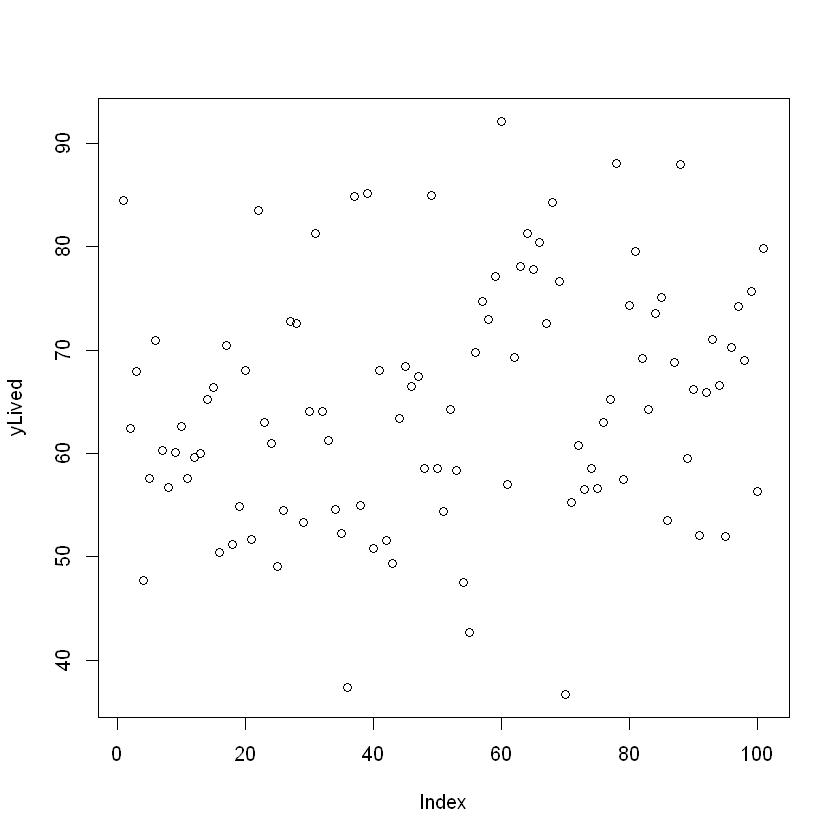

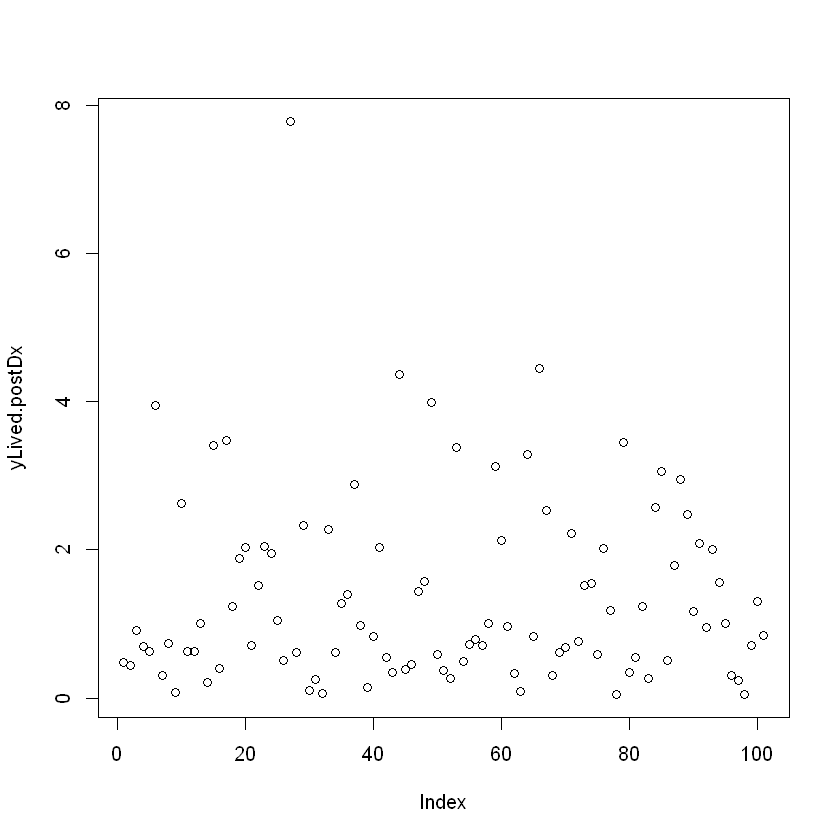

In [7]:
plot(yLived); plot(yLived.postDx)

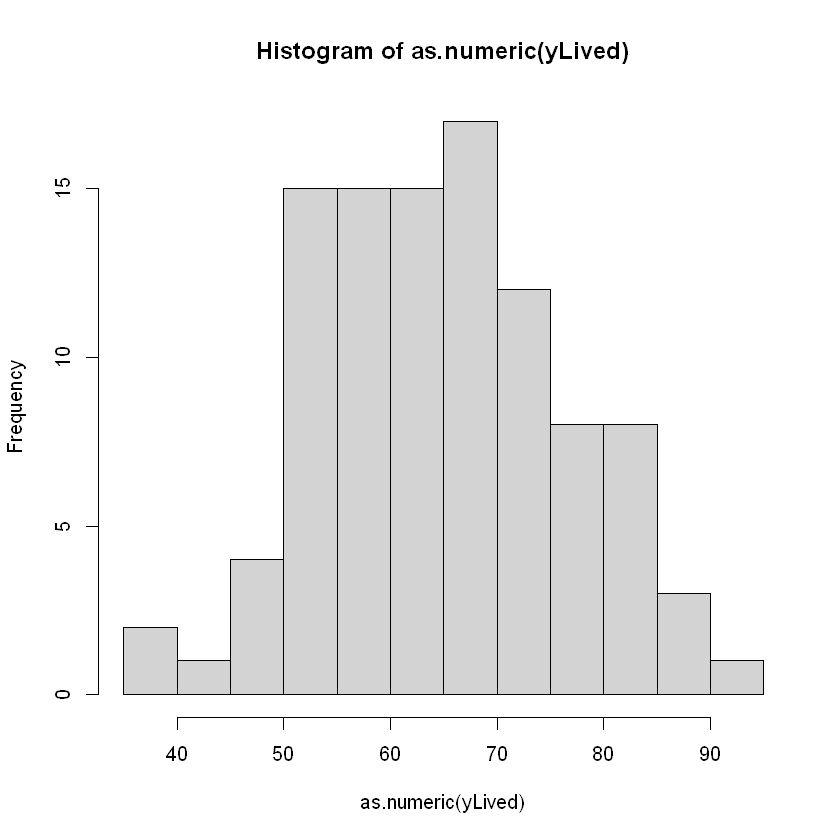

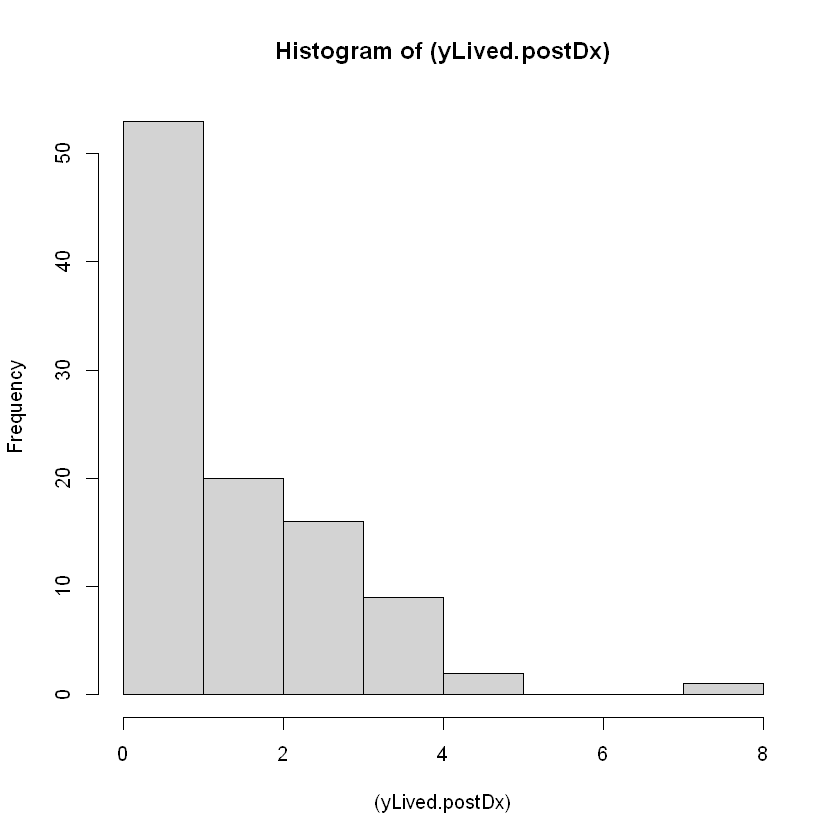

In [8]:
hist(as.numeric(yLived)); hist((yLived.postDx)) # yLived seems Gaussian, and yLived.postDx seems Beta, regarding distribution.

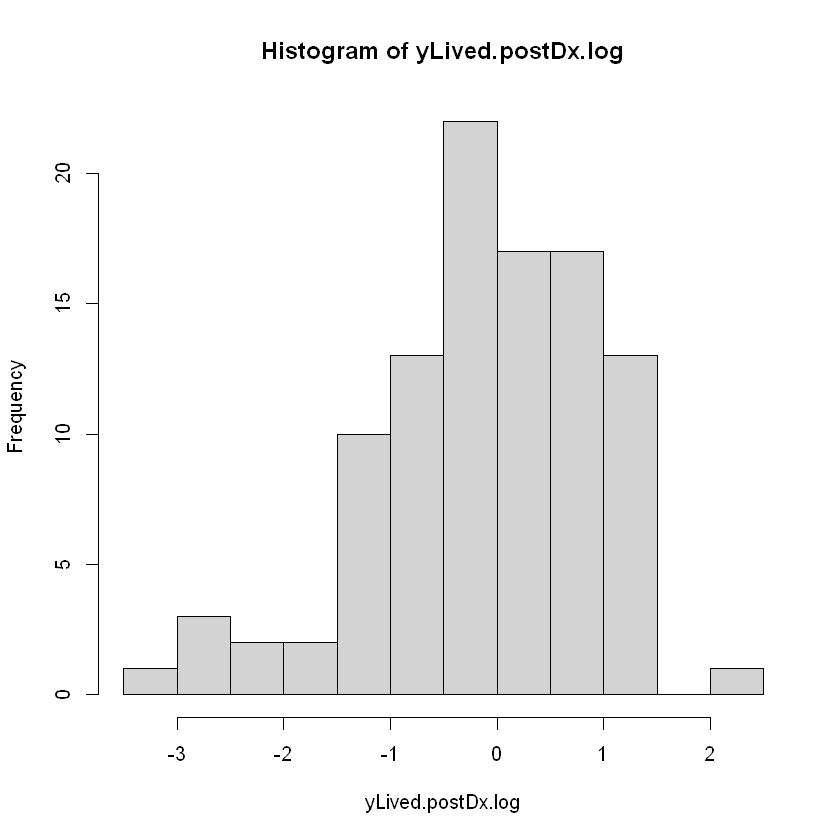

In [9]:
yLived.postDx.log <- log(yLived.postDx); hist(yLived.postDx.log)
f2 <- update(f1, yLived.postDx.log ~ .) # try with log response

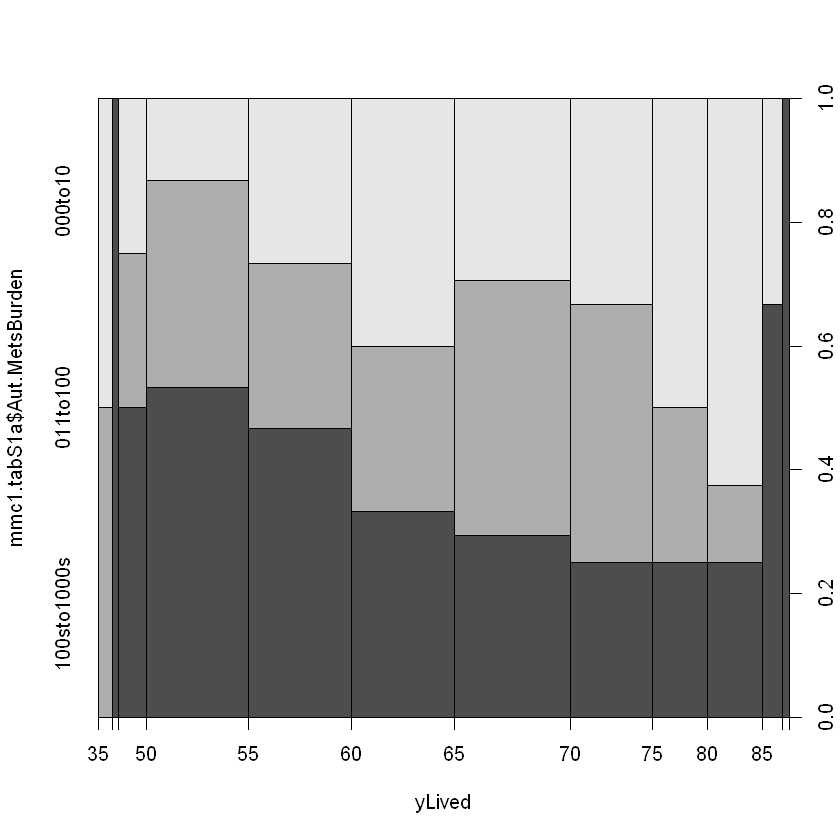

In [10]:
plot(mmc1.tabS1a$Aut.MetsBurden ~ yLived) # trough (bathtub) shaped.

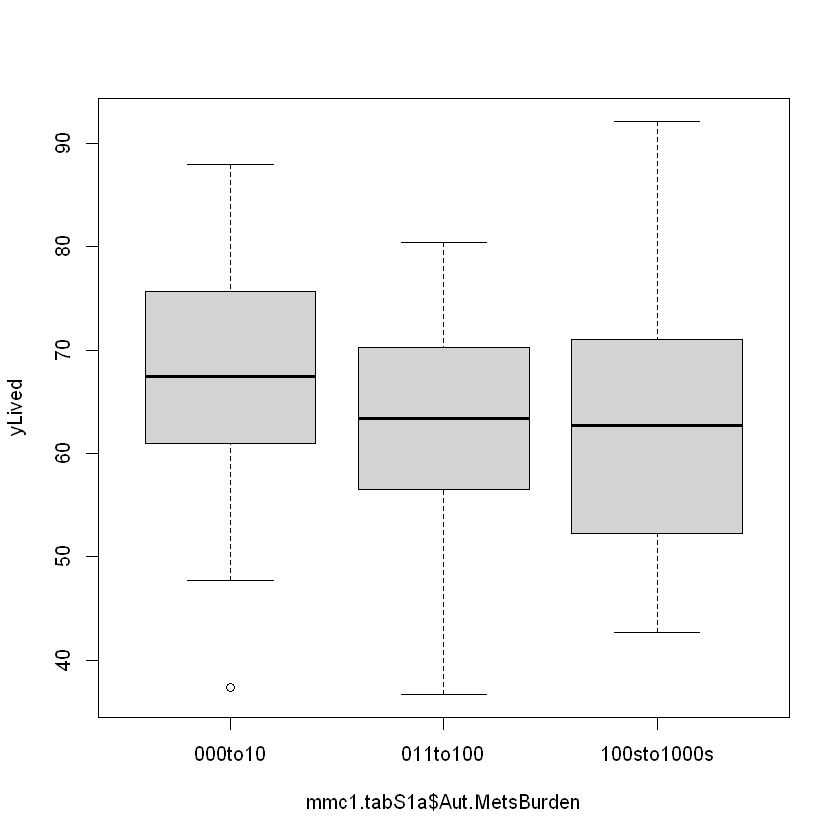

In [11]:
plot(yLived ~ mmc1.tabS1a$Aut.MetsBurden) # raised Aut.MetsBurden seems to relate with lower yLived.

In [12]:
f1.lm <- lm(f1, data=mmc1.tabS1a); summary(f1.lm)


Call:
lm(formula = f1, data = mmc1.tabS1a)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75003 -0.38223 -0.08758  0.20786  2.27946 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)          1.959153   0.709249   2.762  0.00956 **
Dx.Age              -0.009277   0.010288  -0.902  0.37412   
Dx.SzPrim.cm        -0.109631   0.075119  -1.459  0.15451   
Dx.WasPrimExcisYes  -0.048479   0.652555  -0.074  0.94126   
Dx.SzMetsLargest.cm -0.090827   0.046967  -1.934  0.06231 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6378 on 31 degrees of freedom
  (65 observations deleted due to missingness)
Multiple R-squared:  0.2041,	Adjusted R-squared:  0.1014 
F-statistic: 1.988 on 4 and 31 DF,  p-value: 0.121


In [13]:
f1.glm <- glm(f1, data=mmc1.tabS1a); summary(f1.glm)


Call:
glm(formula = f1, data = mmc1.tabS1a)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.75003  -0.38223  -0.08758   0.20786   2.27946  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)          1.959153   0.709249   2.762  0.00956 **
Dx.Age              -0.009277   0.010288  -0.902  0.37412   
Dx.SzPrim.cm        -0.109631   0.075119  -1.459  0.15451   
Dx.WasPrimExcisYes  -0.048479   0.652555  -0.074  0.94126   
Dx.SzMetsLargest.cm -0.090827   0.046967  -1.934  0.06231 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.4068044)

    Null deviance: 15.845  on 35  degrees of freedom
Residual deviance: 12.611  on 31  degrees of freedom
  (65 observations deleted due to missingness)
AIC: 76.401

Number of Fisher Scoring iterations: 2


In [14]:
f1.glm.0intercept <- update(f1.glm, . ~ . - 1)
summary(f1.glm.0intercept)


Call:
glm(formula = I(yLived.postDx) ~ Dx.Age + Dx.SzPrim.cm + Dx.WasPrimExcis + 
    Dx.SzMetsLargest.cm - 1, data = mmc1.tabS1a)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.75003  -0.38223  -0.08758   0.20786   2.27946  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
Dx.Age              -0.009277   0.010288  -0.902  0.37412   
Dx.SzPrim.cm        -0.109631   0.075119  -1.459  0.15451   
Dx.WasPrimExcisNo    1.959153   0.709249   2.762  0.00956 **
Dx.WasPrimExcisYes   1.910674   0.947920   2.016  0.05258 . 
Dx.SzMetsLargest.cm -0.090827   0.046967  -1.934  0.06231 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.4068044)

    Null deviance: 34.611  on 36  degrees of freedom
Residual deviance: 12.611  on 31  degrees of freedom
  (65 observations deleted due to missingness)
AIC: 76.401

Number of Fisher Scoring iterations: 2


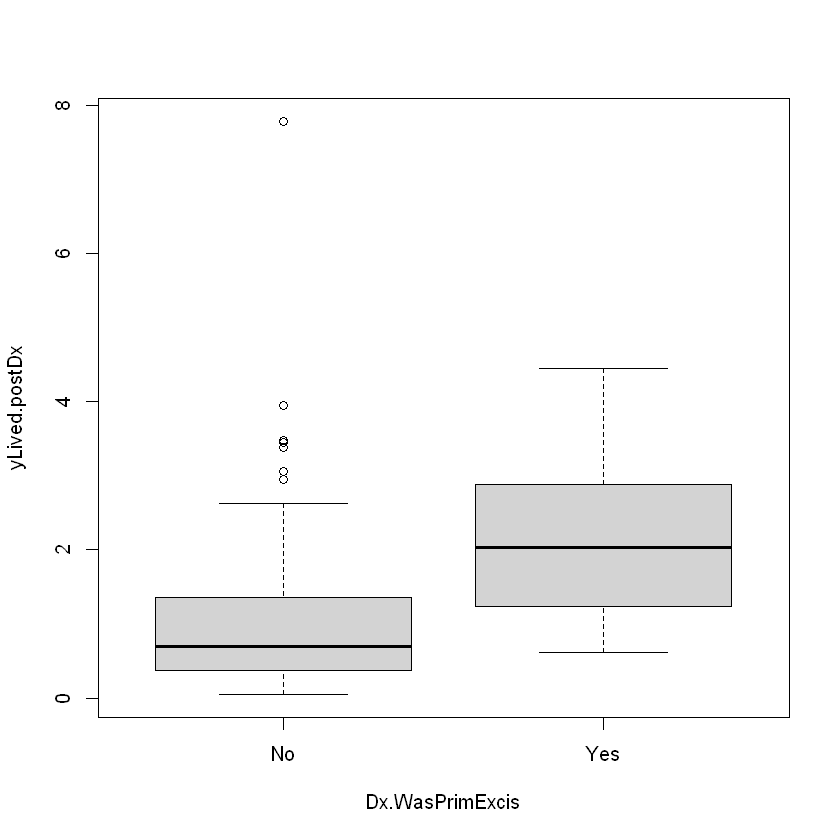

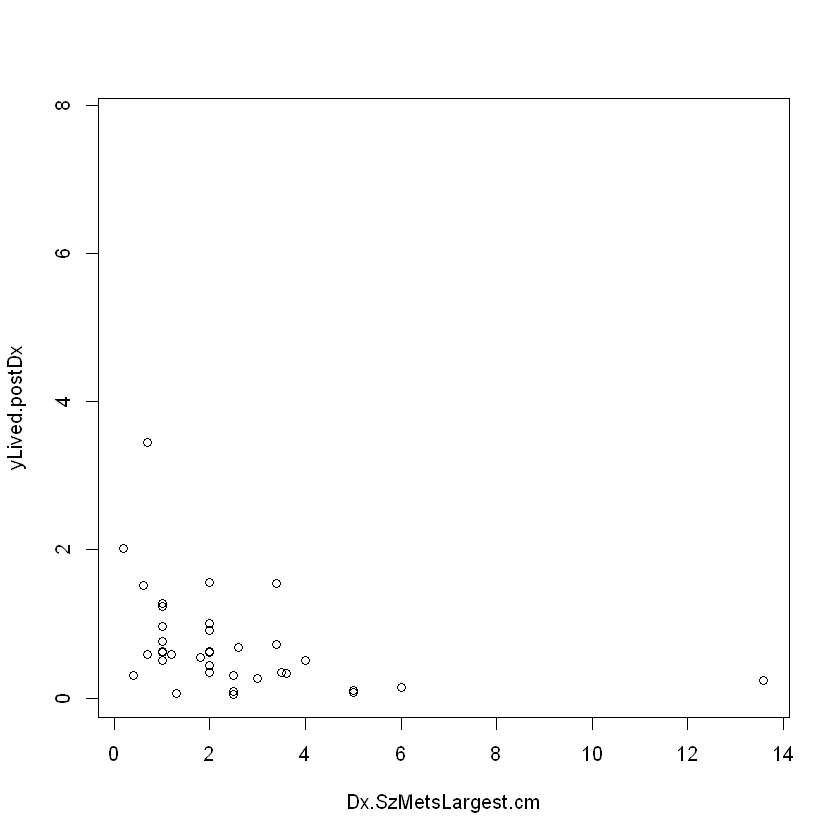

In [15]:
plot(yLived.postDx ~ Dx.WasPrimExcis + Dx.SzMetsLargest.cm, data = mmc1.tabS1a) # mean|No might be higher though median is lower.
  # also beware of attributing causation without considering chron sequence and cause-effect confounding.
  # Erle-Granger tests exist to support such a study, if needed.

In [16]:
f2.lm <- lm(f2, data=mmc1.tabS1a); summary(f2.lm)


Call:
lm(formula = f2, data = mmc1.tabS1a)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2761 -0.3787  0.1271  0.5249  1.4087 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)          1.25934    1.05011   1.199   0.2395  
Dx.Age              -0.02036    0.01523  -1.337   0.1910  
Dx.SzPrim.cm        -0.09293    0.11122  -0.836   0.4098  
Dx.WasPrimExcisYes   0.26553    0.96617   0.275   0.7853  
Dx.SzMetsLargest.cm -0.14644    0.06954  -2.106   0.0434 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9443 on 31 degrees of freedom
  (65 observations deleted due to missingness)
Multiple R-squared:  0.222,	Adjusted R-squared:  0.1216 
F-statistic: 2.211 on 4 and 31 DF,  p-value: 0.09075


In [17]:
f2.glm <- glm(f2, data=mmc1.tabS1a); summary(f2.glm)


Call:
glm(formula = f2, data = mmc1.tabS1a)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2761  -0.3787   0.1271   0.5249   1.4087  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)          1.25934    1.05011   1.199   0.2395  
Dx.Age              -0.02036    0.01523  -1.337   0.1910  
Dx.SzPrim.cm        -0.09293    0.11122  -0.836   0.4098  
Dx.WasPrimExcisYes   0.26553    0.96617   0.275   0.7853  
Dx.SzMetsLargest.cm -0.14644    0.06954  -2.106   0.0434 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.8917844)

    Null deviance: 35.533  on 35  degrees of freedom
Residual deviance: 27.645  on 31  degrees of freedom
  (65 observations deleted due to missingness)
AIC: 104.66

Number of Fisher Scoring iterations: 2


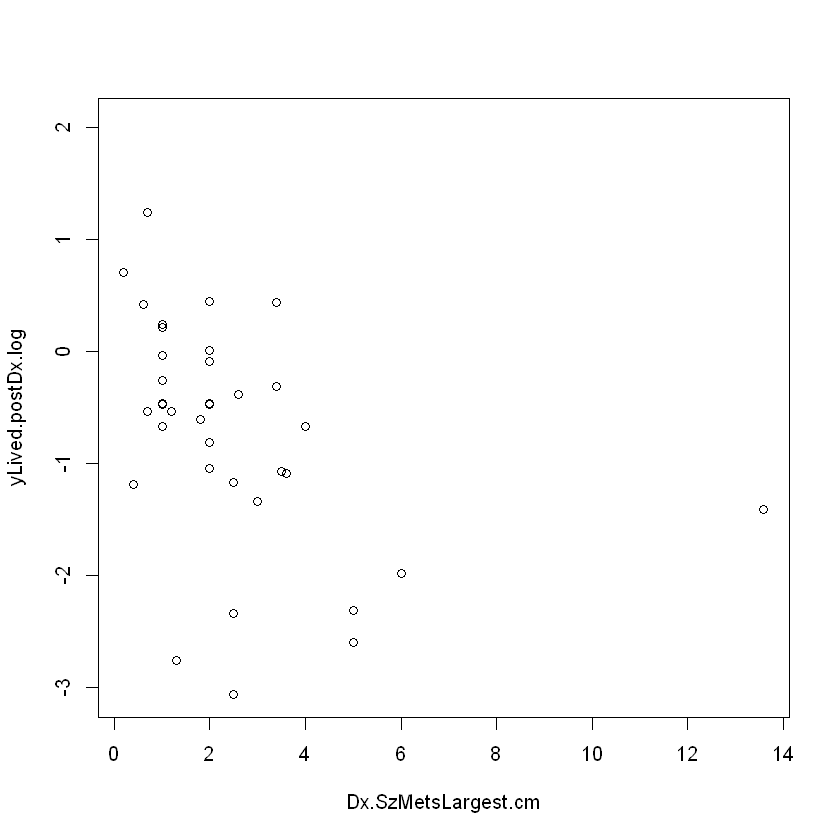

In [18]:
plot(yLived.postDx.log ~ Dx.SzMetsLargest.cm, data=mmc1.tabS1a)

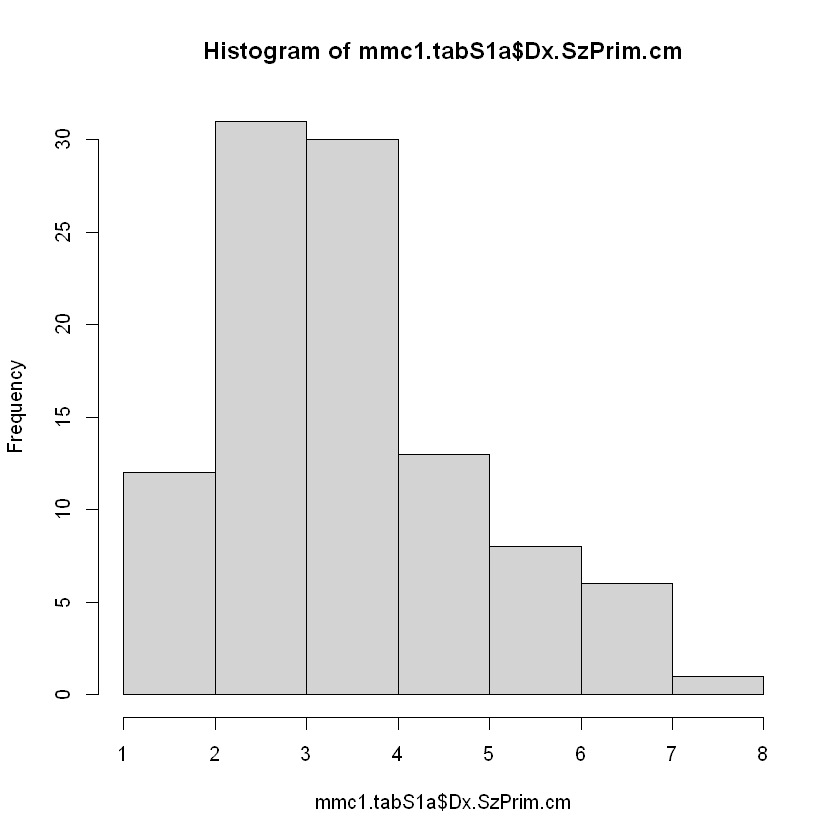

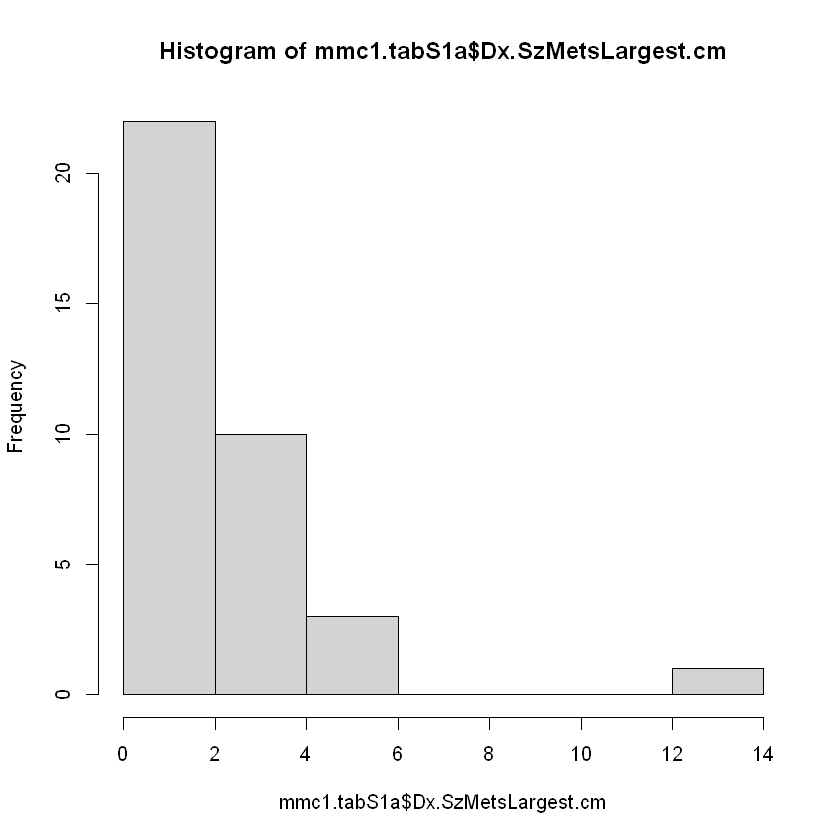

In [19]:
# Paper used normal distributions for tumor sizes and growth rates.
hist(mmc1.tabS1a$Dx.SzPrim.cm); hist(mmc1.tabS1a$Dx.SzMetsLargest.cm)

In [20]:
### ---
### Replicating key elements of the paper:

In [21]:
# Table S1b of 1-s2.0-S0092867411015145-mmc1.xls:
# Dx.SzPrim.cm <3cm >3cm (median-split factor) and its impact on survival: 1 year, 2 year, median ... with p-value.
# Dx.Age <65 >65 (median-split factor) and its impact on survival ...
# neither of above showed significant p-value.

In [22]:
# Table S2A Diameter of 0.2 cm for Undetectable Metastases (with p<0.05 for significance). (cross correlations)
# Table S2B Diameter of 0.05 cm for Undetectable Metastases.
# Table Table S2C Exponential Coefficients of Model Parameters (growth rates of primary and metastastic,
#   Largest Met Dx, Prim removed) with Respect to the Survival Time.

In [23]:
cor.colnames <- c("Dx.SzPrim.cm", "Dx.SzMetsLargest.cm", "Aut.SzPrim.cm", "Aut.maxSzMetsRange.cm")
  # "Aut.MeanSzMetsRange.cm")
  # note: the paper's Tables S2A and S2B refer to a "Largest metastasis at autopsy" instead of Aut.MeanSzMetsRange.cm;
  # maybe that's max of Aut.SzMetsRange.cm, and so, use Aut.maxSzMetsRange.cm
  # the paper also refers to "Primary growth rate", "Metastasis growth rate", and "Survival".
# var(mmc1.tabS1a[, cor.colnames], na.rm=TRUE)
mmc1.tabS1a.cor <- cor(mmc1.tabS1a[, cor.colnames],
    use=c("everything", "all.obs", "complete.obs", "na.or.complete", "pairwise.complete.obs")[3],
                       # use="pairwise.complete.obs"
    method=c("pearson", "kendall", "spearman")[1])
round(mmc1.tabS1a.cor, 2)

,Dx.SzPrim.cm,Dx.SzMetsLargest.cm,Aut.SzPrim.cm,Aut.maxSzMetsRange.cm
Dx.SzPrim.cm,1.00,0.06,0.59,-0.02
Dx.SzMetsLargest.cm,0.06,1.00,-0.05,0.92
Aut.SzPrim.cm,0.59,-0.05,1.00,-0.03
Aut.maxSzMetsRange.cm,-0.02,0.92,-0.03,1.00


Loading required package: corrplot

corrplot 0.92 loaded



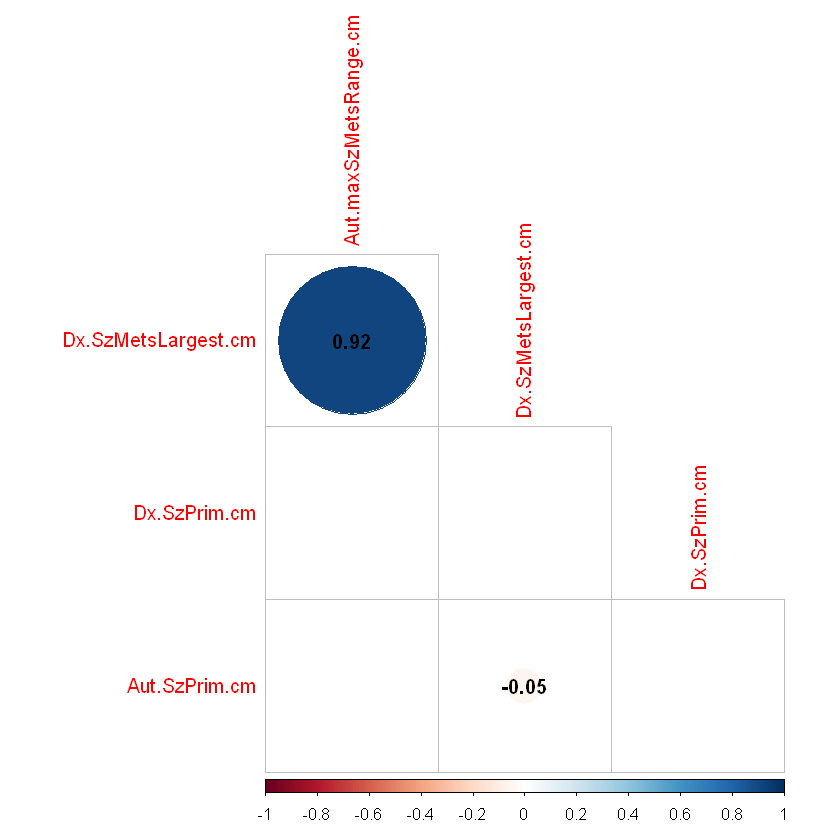

In [24]:
# ref: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
require(corrplot)
chooseTblock <- FALSE
M <- mmc1.tabS1a.cor
testRes <- cor.mtest(M, conf.level=0.95)
if(chooseTblock){
    ## leave blank on non-significant coefficient
    ## add all correlation coefficients
    corrplot(M, p.mat=testRes$p, method=c('color', 'circle')[2],
             type='lower', insig=c('p-value', 'label_sig', 'blank')[3],
             # sig.level=c(0.001, 0.01, 0.05), # sig.level=-1,
             order='AOE', diag=FALSE)$corrPos -> p1
    text(p1$x, p1$y, round(p1$corr, 2))
} else {
    ## leave blank on non-significant coefficient
    ## add significant correlation coefficients
    corrplot(M, p.mat=testRes$p, method='circle', type='lower', insig='blank',
             addCoef.col='black', number.cex=1.0, order='AOE', diag=FALSE)
}

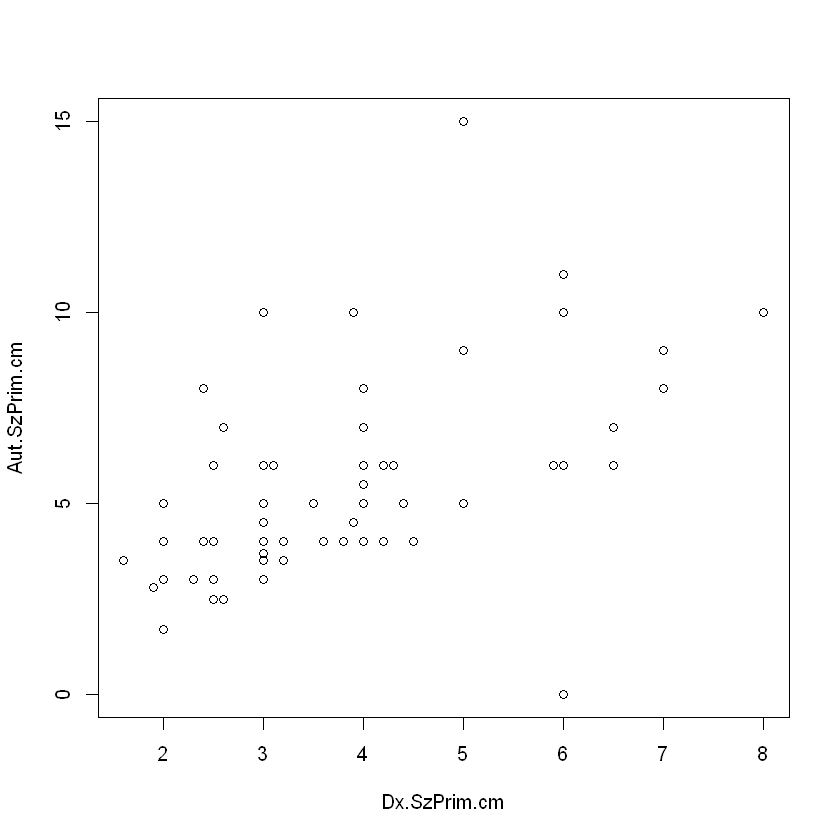

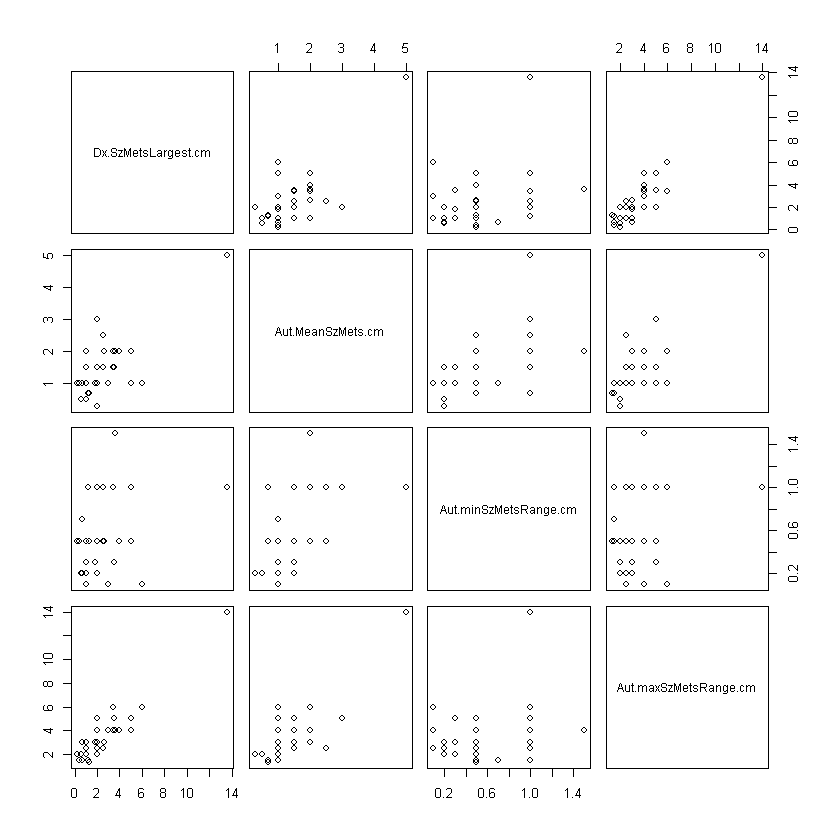

NULL

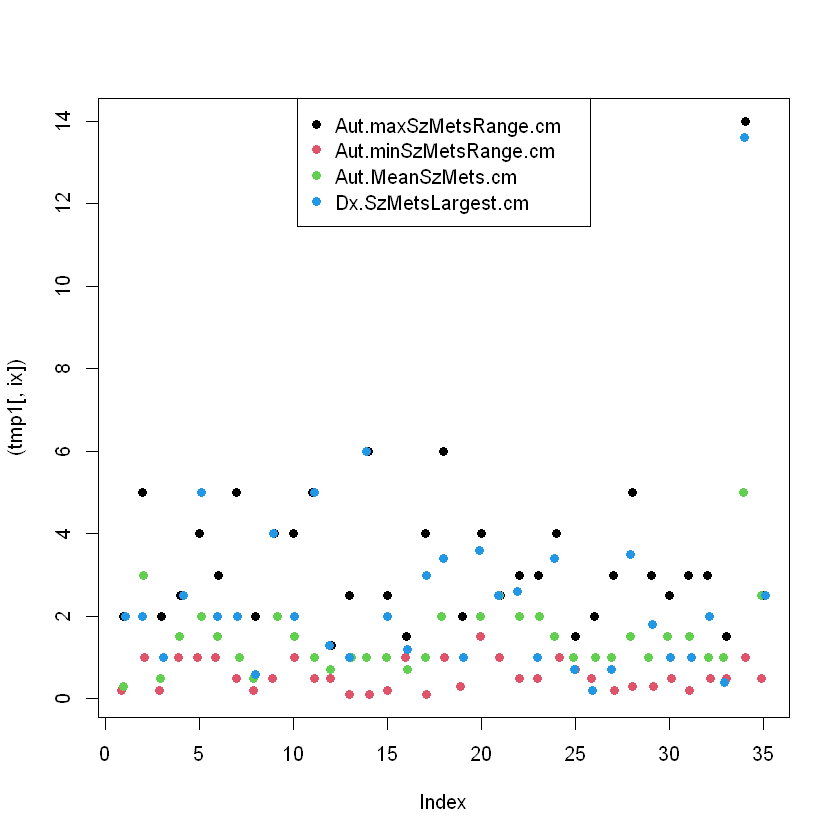

In [25]:
plotProgression(mmc1.tabS1a, jitterFactor=0.75)

In [26]:
mustInstall <- c(TRUE, FALSE)[2] # [1] for installing packages; [2] otherwise ie to only load needed libraries.
if(mustInstall){ # This code block fails on R3.6.2 on Windows. Maybe this expects R4.0+. For now, do without survminer.
    # remove.packages("rlang")
    # ref Bioconductor r-survival.html:
    # install.packages("Rtools") # Downloaded .exe for Windows from www.
    # install.packages("glue", type="binary") # fails otherwise when (loading namespace for) compiling source.
    # devtools::install_github("tidyverse/glue")
    # remotes::install_github("tidyverse/glue") # ref https://github.com/tidyverse/glue/issues/188. Fails.
    install.packages(c("tidyselect", "ggpubr", "broom", "survminer"), type="binary")
      # worked after installing R4.2! refer https://cran.r-project.org/web/packages/IRkernel/readme/README.html.
} # else continue as is.
library(survival)
library(dplyr) # or library(tidyverse) for as_tibble()
library(survminer)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma




In [27]:
panc <- mmc1.tabS1a[, c("Case", "Dx.Age", "Dx.SzPrim.cm", "Dx.WasPrimExcis")]
panc <- cbind(panc, time=(mmc1.tabS1a$Aut.DateDeath - mmc1.tabS1a$Dx.Date),
  status=rep(2, count=nrow(panc))) # similar to `lung`, `time` is elapsed days; censoring `status` 2=dead ie event completed.
panc <- as_tibble(panc); str(panc)

tibble [101 x 6] (S3: tbl_df/tbl/data.frame)
 $ Case           : Factor w/ 101 levels "1","2","3","5",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Dx.Age         : int [1:101] 84 62 67 47 57 67 60 56 60 60 ...
 $ Dx.SzPrim.cm   : num [1:101] 6 3 2 5 4 8 5 3 6 4 ...
 $ Dx.WasPrimExcis: Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ time           : 'difftime' num [1:101] 174 161 334 256 ...
  ..- attr(*, "units")= chr "days"
 $ status         : num [1:101] 2 2 2 2 2 2 2 2 2 2 ...


In [28]:
s <- Surv(panc$time, panc$status)
class(s)
head(s)

[1] "Surv"

[1]  174  161  334  256  229 1443

In [29]:
sfit1.fmla <- as.formula(s ~ 1)
sfit1 <- survfit(sfit1.fmla, data=panc) # alt: survfit(s ~ 1). alt: survfit(Surv(time, status) ~ 1).
sfit1
summary(sfit1)

Call: survfit(formula = sfit1.fmla, data = panc)

       n events median 0.95LCL 0.95UCL
[1,] 101    101    347     260     464

Call: survfit(formula = sfit1.fmla, data = panc)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
   17    101       1   0.9901 0.00985      0.97098       1.0000
   20    100       1   0.9802 0.01386      0.95340       1.0000
   23     99       1   0.9703 0.01689      0.93775       1.0000
   27     98       1   0.9604 0.01941      0.92310       0.9992
   35     97       1   0.9505 0.02158      0.90912       0.9938
   36     96       1   0.9406 0.02352      0.89561       0.9878
   50     95       1   0.9307 0.02527      0.88246       0.9816
   77     94       1   0.9208 0.02687      0.86960       0.9750
   89     93       1   0.9109 0.02835      0.85699       0.9682
   92     92       1   0.9010 0.02972      0.84458       0.9612
   95     91       2   0.8812 0.03220      0.82029       0.9466
  109     89       1   0.8713 0.03332      0.80836       0.9391
  111     88       1   0.8614 0.03438      0.79657       0.9315
  113     87       1   0.8515 0.03538      0.78488    

In [30]:
sfit2 <- update(sfit1, . ~ Dx.WasPrimExcis)
sfit2
summary(sfit2)

Call: survfit(formula = s ~ Dx.WasPrimExcis, data = panc)

                     n events median 0.95LCL 0.95UCL
Dx.WasPrimExcis=No  75     75    256     213     359
Dx.WasPrimExcis=Yes 26     26    744     689    1054

Call: survfit(formula = s ~ Dx.WasPrimExcis, data = panc)

                Dx.WasPrimExcis=No 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
   17     75       1   0.9867  0.0132      0.96105       1.0000
   20     74       1   0.9733  0.0186      0.93755       1.0000
   23     73       1   0.9600  0.0226      0.91666       1.0000
   27     72       1   0.9467  0.0259      0.89716       0.9989
   35     71       1   0.9333  0.0288      0.87855       0.9915
   36     70       1   0.9200  0.0313      0.86061       0.9835
   50     69       1   0.9067  0.0336      0.84316       0.9750
   77     68       1   0.8933  0.0356      0.82613       0.9660
   89     67       1   0.8800  0.0375      0.80944       0.9567
   92     66       1   0.8667  0.0393      0.79305       0.9471
   95     65       2   0.8400  0.0423      0.76100       0.9272
  109     63       1   0.8267  0.0437      0.74529       0.9169
  111     62       1   0.8133  0.0450      0.72976       0.9065
  113    

In [31]:
# ?summary.survfit
range(panc$time)
summary(sfit2, times=seq(1, 1100, 100))

Time differences in days
[1]   17 2841

Call: survfit(formula = s ~ Dx.WasPrimExcis, data = panc)

                Dx.WasPrimExcis=No 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     75       0   1.0000  0.0000       1.0000        1.000
  101     63      12   0.8400  0.0423       0.7610        0.927
  201     46      17   0.6133  0.0562       0.5125        0.734
  301     33      13   0.4400  0.0573       0.3409        0.568
  401     23      10   0.3067  0.0532       0.2182        0.431
  501     19       4   0.2533  0.0502       0.1718        0.374
  601     13       6   0.1733  0.0437       0.1057        0.284
  701     12       1   0.1600  0.0423       0.0953        0.269
  801     11       1   0.1467  0.0409       0.0850        0.253
  901     10       1   0.1333  0.0393       0.0749        0.237
 1001      7       3   0.0933  0.0336       0.0461        0.189

                Dx.WasPrimExcis=Yes 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     26       0    1.000  0.00

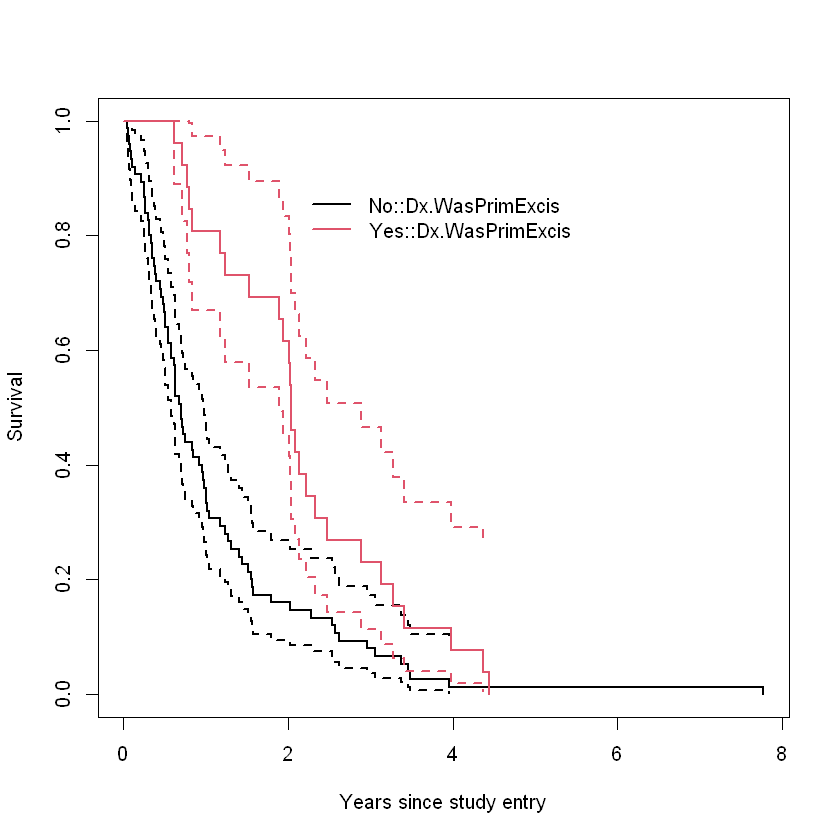

In [32]:
# ref `survival` vignette.
# Kaplan-Meier plots:
plot(sfit2, col=1:2, xscale=365.25, lwd=2, mark.time=TRUE, # mark.time=TRUE means mark each censoring time; else specify vector.
     conf.int=TRUE,
     xlab="Years since study entry", ylab="Survival")
legend(750, .9, paste0(levels(panc$Dx.WasPrimExcis), "::Dx.WasPrimExcis"), # c("No residual disease", "Residual disease"),
       col=1:length(levels(panc$Dx.WasPrimExcis)), lwd=2, bty='n')

In [33]:
# Relevant excerpts from the paper:
# [Here we utilize one of these highly
# unique patient datasets derived from a rapid autopsy program
# for patients with pancreatic cancer, together with a mathematical
# framework of pancreatic metastasis development, to understand
# the growth dynamics of cancer metastasis in the setting
# of commonly used anti-cancer therapies. This model is subsequently
# validated using a uniform cohort of patients who underwent
# curative resection ...]
# [RESULTS ... at least one intermediate evaluation
# of the primary tumor, local and distant recurrence as well as
# metastases was available.]
# [Using the 47 patients who had at least one intermediate time
# point between diagnosis and autopsy, we compared the fit of
# linear and exponential growth models of primary and metastatic
# tumors. The exponential model had a better fit than the linear
# model in 71% of the cases, with a median R2 of 0.63 (0.24–
# 0.88). Other growth models such as a logistic model did not
# converge for most patients, due to sparsity of the data.]
# [Survival times were calculated from diagnosis to death, and
# growth rates of primary and metastatic tumors were computed
# using our exponential growth model. For some patients, no
# tumor was detected at a given location (primary or metastatic)
# at a given time (diagnosis, intermediate evaluations, or autopsy).
# We imputed a tumor size of 0.1 cm for those time points, based
# on estimates of the minimal size of radiographically detectable
# local and metastatic tumors ...]
# [We then estimated the model parameters using the autopsy
# patient cohort (see Extended Experimental Procedures and
# Table S2C). The coefficients in Table S2C are on a multiplicative
# scale; for example, surgical removal of the primary almost
# doubles predicted survival (e0.632 = 1.88) when growth rates
# and size of the largest metastatic tumor at diagnosis were held
# constant.]

In [34]:
# [Table 2. Correlations between Various Measures of Tumor Size and Growth Rate as Well as Survival in the Autopsy Cohort]

In [35]:
# [Figure 2. The Predictions of the Mathematical Framework Are Validated Using Patient Data
# (A and B) The panels show the distribution of survival times of patients who were diagnosed with primary
# tumors with a diameter ...]
# [Figure 3. Validation of Our Framework Using an Independent Patient Cohort
# (A) The distribution of the primary growth rate from the original dataset including 101 patients is shown in blue ...
# (B) The panel shows the distribution of survival times of patients after resection of the primary tumor with
# 2 (1.5–2.4) cm diameter after diagnosis.]
# [Figure 4. The Mathematical Framework Predicts Optimum Treatment Strategies for Pancreatic Cancer Patients ...
# for a tumor size of 1 cm diameter at diagnosis (left column) and 3 cm at diagnosis (right column) ...
# The black curve represents mathematical predictions of the survival time without treatment or resection ...]

In [36]:
# [EXTENDED EXPERIMENTAL PROCEDURES
# Statistical Analyses
# Although analysis of survival times is a central focus of this paper, we were not forced to use traditional
# survival analysis techniques, such as Kaplan-Meier estimates or proportional hazards regression, since every
# patient in our autopsy patient series was dead and we had complete information on survival times.
# For this reason, we explored more flexible and robust methods. ...
# we used the M-method of Huber (Huber, 1973) with a bi-square weight function and the
# median method to estimate the scale parameter. The advantages of this method over least-squares is that
# it gives higher weights to data points closer to the center and less weights to those in the tails,
# minimizing the influence of outliers. No leverage points were identified.]

In [37]:
# [Figure S1. Statistical Analysis of the Pancreatic Cancer Patient Dataset Containing 101 Patients
# (A) Correlations between growth rates of primary and metastatic tumors and log-survival time. Primary tumors
# are shown in black while metastatic tumors are shown in white.
# (B) Distribution of the standardized residuals from the multiplicative robust regression model of survival times
# and the factors listed in Table S2C. There is no evidence of poor fit based on this residual plot.
# (C) Q-Q plot for the residuals. The horizontal axis represents the quantile from the normal distribution and
# the vertical axis the quantile of the standardized residual. With most points on or near the line of equality,
# this figure indicates no serious departures from the presumed regression model.]

In [38]:
# Proposals for evolving this Jupyter Notebook:
# P1. Survival estimates and curves (and with covariates) using (a) classical methods of KM estimation and PH regression
# and (b) M-method of Huber as used by the paper.
# P2. Multi-state survival analysis considering state-space transition models and competing risks, which the paper does not
# seem to have done. (Refer "2.4 Multi-state data" in `survival` vignette pages 24-44.)
# Cumulative Hazard via cumhaz=TRUE which is relevant for multi-event scenarios eg recurrence and other progression events.
# P3. Survival analyses using deep learning, which the paper does not seem to have done.
# P4. Submit on GitHub. Include on LinkedIn.